# Experience 8: Convection with the Biharmonic and Diffusion Equations 

In [4]:
import numpy as np 
import scipy.sparse.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

Today, we put together everything we have learned until now to create a code that models convection. The steps to follow are:
1. learn to have non-zero boundary conditions for the diffusion equation (becuase later, we want to have a hot bottom and cold top)
2. learn to use the vectorizedUpwind, a fast technique to advect flow
3. put everything together in a convection algorithm and discover the critical Rayleigh number at which convection starts

Let's create our mesh first:

In [5]:
nxp=51; nxc=nxp-1; xTot=1.0; 
nyp=51; nyc=nyp-1; yTot=1.0; 

dx=xTot/nxc; xMin=-xTot/2.0; xMax=xTot/2.0
dy=yTot/nyc; yMin=-yTot/2.0; yMax=yTot/2.0

### Diffusion equation with non-zero boundary conditions

The first step is to rebuild our library of operators that allow us to project values to the center of the sides of each cell and to create gradients and Laplacian.

In [31]:
# Functional approach to the calculation of the Laplacian
def buildSparseOperatorXaxis(nx,ny,k1,k2):
    nx1=nx-1
    firstDiag=np.ones(nx*ny,float)*k1
    secondDiag=np.ones(nx*ny,float)*k2
    offsets=np.array([0,ny])
    return ( sparse.dia_matrix(([firstDiag,secondDiag],offsets), shape=(nx1*ny,nx*ny)).tocsr() )           

def buildSparseOperatorYaxis(nx,ny,k1,k2):
    ny1=ny-1
    firstDiag=np.ones(ny,float)*k1
    secondDiag=np.ones(ny,float)*k2
    offsets=np.array([0,1])
    block = sparse.dia_matrix(([firstDiag,secondDiag],offsets), shape=(ny1,ny)).tocsr()
    return (sparse.kron(sparse.eye(nx),block))

def sparseGradientOperator(nxp,nyp,dx,dy):
    DxOp = buildSparseOperatorXaxis(nxp,nyp-1,-1.0/dx,1.0/dx) 
    DyOp = buildSparseOperatorYaxis(nxp-1,nyp,-1.0/dy,1.0/dy) 
    sideXOp=buildSparseOperatorYaxis(nxp,nyp, 0.5, 0.5) 
    sideYOp=buildSparseOperatorXaxis(nxp,nyp, 0.5, 0.5) 
    return(DxOp.dot(sideXOp),DyOp.dot(sideYOp))

def sparseLaplacianOperator(nxp,nyp,dx,dy): 
    (cellDxOp,cellDyOp)=sparseGradientOperator(nxp,nyp,dx,dy) 
    (cellDxOpSmall,cellDyOpSmall) = sparseGradientOperator(nxp-1,nyp-1,dx,dy) 
    return(cellDxOpSmall.dot(cellDxOp)+cellDyOpSmall.dot(cellDyOp))

def addBC(operatorWithoutBC,nxp,nyp): # add Boundary Conditions nxy=nxp*nyp
    nxy=nxp*nyp
    operatorWithBC=sparse.lil_matrix((nxy,nxy))
    indexes = np.arange(nxy)
  # selects only the interior points
    oldLines = (indexes>=nyp) * (indexes<=nxy-nyp) * (indexes % nyp != 0) * (indexes % nyp != nyp-1) 
    operatorWithBC[oldLines,:]=operatorWithoutBC[:,:] 
    operatorWithBC[~oldLines,~oldLines]=1.0
    return operatorWithBC

Second, we consider the solution of the diffusion equation as 

\begin{equation}
\left( 1+4r \right) T^{t+\Delta t} \left( x_i,y_j \right) -r T^{t+\Delta t} \left( x_i,y_{j+1} \right) -r T^{t+\Delta t} \left( x_i,y_{j-1} \right) -r T^{t+\Delta t} \left( x_{i+1},y_{j} \right) -r T^{t+\Delta t} \left( x_{i+1},y_{j} \right)  = T^t \left( x_i,y_j \right)
\label{eq-diff-impl-2D-2}
\end{equation}

Using our operators

In [30]:
r = deltaTime*diffusivity/(dx*dy)
LaplacianOp=sparseLaplacianOperator(nxp,nyp,dx,dy) #create laplacian operator A
LaplacianOp=addBC(LaplacianOp,nxp,nyp)*r*dx*dy  # add boundary conditions
IA=sparse.eye(nxp*nyp).tocsc()-LaplacianOp  # I-A # create the I-A operator for diffusion
np.shape(LaplacianOp)
print(nxp, nyp)

(1, 200)
51 51


And now we recreate the solver for the diffusion equation, but this time we change the boundary conditions:

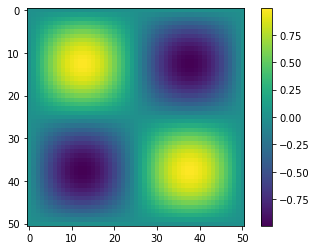

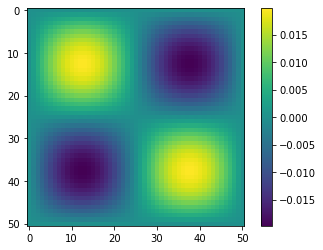

In [35]:
steps=1000; totalTime=1.0; plotEverySteps = 100; 
deltaTime=totalTime/steps; diffusivity=5e-2; 


X=np.arange(nxp)*dx+xMin
Y=np.arange(nyp)*dy+yMin
T=np.outer(np.sin(2*np.pi*X),np.sin(2*np.pi*Y))

for thisStep in np.arange(steps):
    T = la.spsolve(IA,T.reshape(nxp*nyp)).reshape(nxp,nyp)
    if thisStep == 0 or thisStep == steps-1:
        plt.imshow(T);plt.colorbar();plt.show()

You can find the solution much more rapidly by running it without visualizing each step. Try to visualize only the first and last step.

### Exercise 1
As an exercise, try to add boundary conditions. The fact is that you don't have to really add anything. You already used **addBC()** when creating the Laplacian. In **addBC()**, we have set to *identity* the value for the boundary nodes. For this reason, you just have to set the value of the temperature to what you think it should be (set the top to 1 and the bottom to -1, for example) and see how the solver evolves. 
 

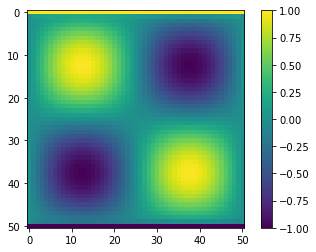

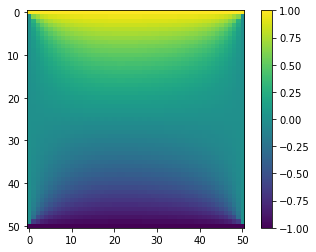

In [36]:
# here you can write your solution
X=np.arange(nxp)*dx+xMin
Y=np.arange(nyp)*dy+yMin
T=np.outer(np.sin(2*np.pi*X),np.sin(2*np.pi*Y))

for thisStep in np.arange(steps):
    T[0,:] = 1
    T[-1,:] = -1
    T = la.spsolve(IA,T.reshape(nxp*nyp)).reshape(nxp,nyp)
    if thisStep == 0 or thisStep == steps-1:
        plt.imshow(T);plt.colorbar();plt.show()

### Vectorized Upwind

When gradients are not very steep (for example for thermally driven convection), a  convenient and not memory and computing demanding algorithm is possible. Let us look now at how a less accurate but much faster, less memory consuming and always balanced approach can be written and simply vectorized.

The most well-known algorithm is called the *Upwind scheme* and is based on the simple idea that every total derivative respect to space of a field of a moving fluid can be expressed as the product of the velocity field for the gradient of the field itself:

\begin{equation}
\frac{d F}{d t} = \frac{\partial F}{\partial t} + \frac{\partial x_i}{\partial t} \frac{\partial F}{\partial x_i} = \frac{\partial F}{\partial t} + v_i \frac{\partial F}{\partial x_i}
\end{equation}  

The terms on the right to the Eulerian derivative are given by the product of the velocity multiplied to the gradient. This simple technique is very old and was already introduced by Courant and co-workers in 1965. Its stability is also defined by the so called Courant criterium $v \delta t / \Delta x < 1$. While the advantage of this approach is clearly speed and minimized memory usage (compared to using particles, for example) it is subjected to quite a substantial diffusion of sharp gradients, which makes its use inappropriate for accurate tracking of material boundaries.

A modern version of this algorithm is the so-called \emph{Donor-Cell algorithm}. Its goal is the same, but it is based on fluxes, therefore its physical interpretation is more clear. When the material flows from left to
right ($v_x>0$), then the flux of the field $F$ through the interface between one cell and the next is $F_{leftCell} \dot v_x^{left} - F_{Cell} \dot v_x^{right}$, while if $v_x<0$ the flux is $F_{Cell} \dot v_x^{right} - F_{rightCell} \dot v_x^{left}$. 

To vectorize the donor-cell method the simplest approach is to calculate the flux through the each cell and then use a boolean index and its negative (not index) to select which direction for the flow needs to be taken. This is done for every axis separately. It follows here an example in 2D.    


In [37]:
def vectorizedUpwind(F,vx,vy,dx,dy,dt): 
    (nx,ny) = F.shape
    dFplus = np.zeros((nx,ny),float) 
    dFminus = np.zeros((nx,ny),float) 
    dF_dt = np.zeros((nx,ny),float)
    
    ind = vx>0.0 # flag array for x upwind 
    ind[0,:] = True; ind[nx-1,:]=False
    
    dFplus[1:-1,:] = (F[:-2,:]*vx[1:-1,:] - F[1:-1,:]*vx[2:,:])/dx 
    dFminus[1:-1,:] = (F[1:-1,:]*vx[1:-1,:] - F[2:,:]*vx[2:,:])/dx 
    dF_dt = (ind * dFplus + ~ind * dFminus)
    
    ind = vy>0.0 # flag array for y upwind 
    ind[:,0] = True; ind[:,ny-1]=False
    
    dFplus[:,1:-1] = (F[:,:-2]*vy[:,1:-1] - F[:,1:-1]*vy[:,2:])/dy 
    dFminus[:,1:-1] = (F[:,1:-1]*vy[:,1:-1] - F[:,2:]*vy[:,2:])/dy
    dF_dt += (ind * dFplus + ~ind * dFminus) 
    
    return (F + dt * dF_dt)


To test how efficient is this advection scheme, we need a flow. A very practical flow was introduced by Bell about 20 years ago, for helping visual scientists to benchmark their advection schemes. 

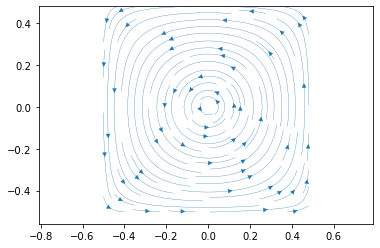

In [38]:
# Bell's flow
X=np.arange(nxp)*dx+xMin
Y=np.arange(nyp)*dy+yMin

vx=np.zeros((nxp,nyp), float)
vy=np.zeros((nxp,nyp), float)

xNorm=(X+xMin)/xTot
yNorm=(Y+yMin)/yTot
for iy in np.arange(0,nyp):
    vx[:,iy] = np.sin(np.pi*xNorm) * np.sin(np.pi*xNorm) * np.sin(np.pi*yNorm[iy]) * np.cos(np.pi*yNorm[iy])
for ix in np.arange(0,nxp):
    vy[ix,:] =- np.sin(np.pi*yNorm) * np.sin(np.pi*yNorm) * np.sin(np.pi*xNorm[ix]) * np.cos(np.pi*xNorm[ix])
    
plt.streamplot( X[0:nxc], Y[0:nyc], vx[0:nxc,0:nyc].transpose(), vy[0:nxc,0:nyc].transpose(), linewidth=.3)
plt.axis("equal")
plt.show()

### Exercise 2
Write a function that takes the Bell's flow, and advects a circular anomaly, as in Experience 4 on kinematic motion in 2 dimensions. 

0.5


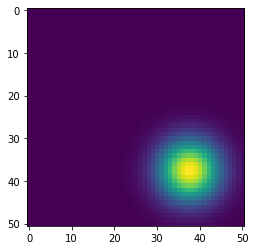

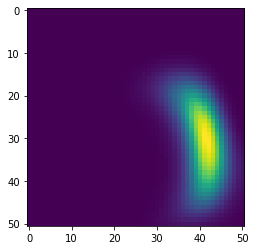

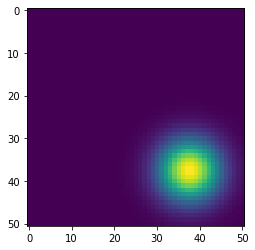

0.6


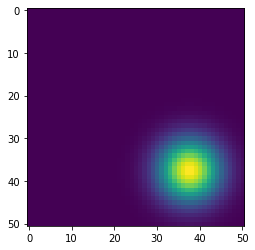

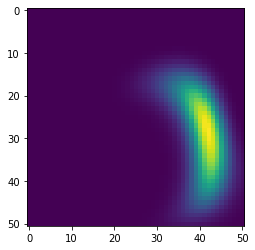

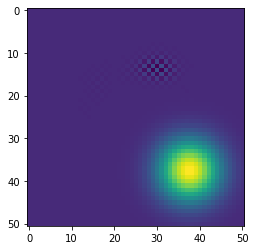

0.7


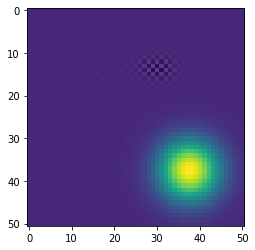

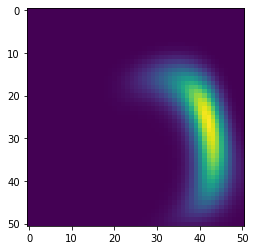

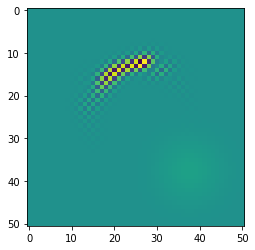

0.7999999999999999


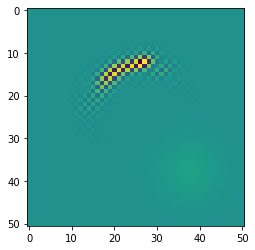

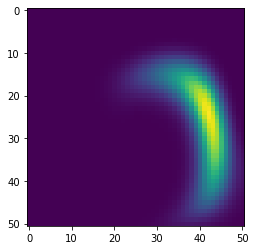

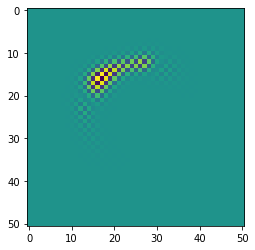

0.8999999999999999


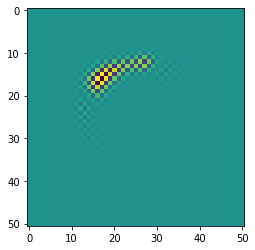

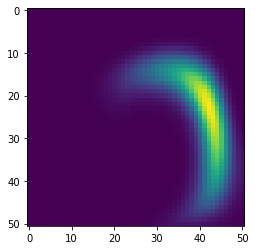

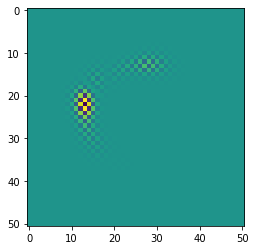

0.9999999999999999


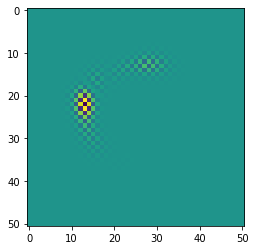

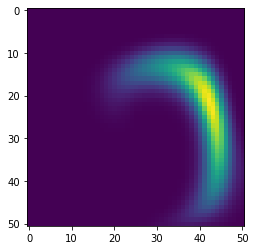

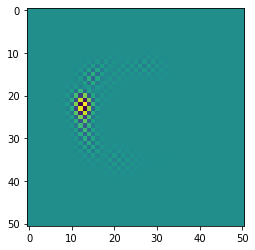

1.0999999999999999


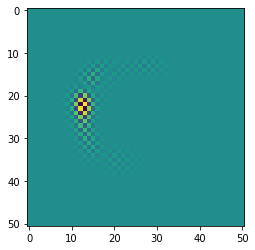

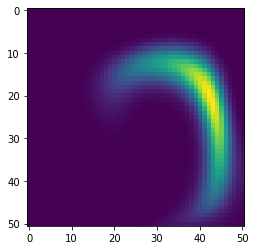

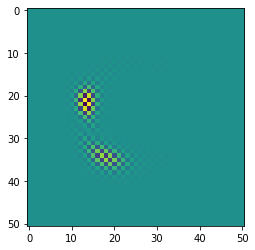

1.1999999999999997


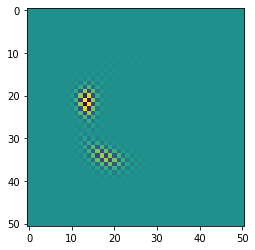

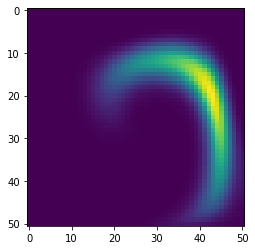

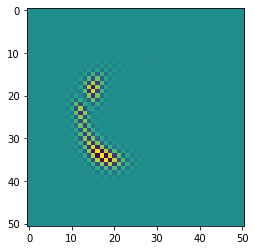

1.2999999999999998


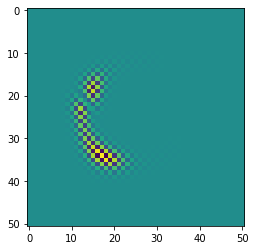

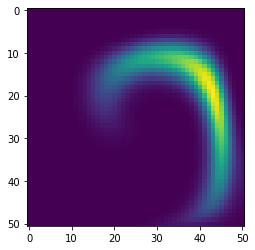

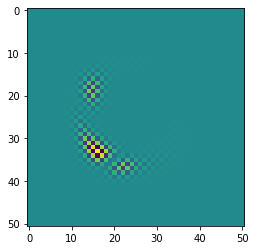

1.4


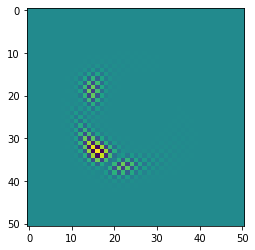

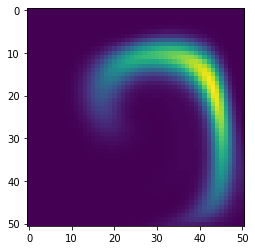

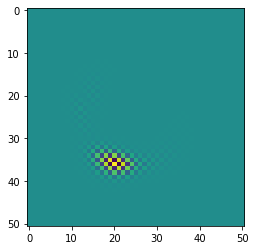

In [87]:
# use this anomaly for example
T=np.zeros((nxp,nyp), float) #mesh
T= np.outer(np.exp(-(X-xTot/4)**2*50/xTot**2),np.exp(-(Y-yTot/4)**2*50/yTot**2))
plt.imshow(T)
# here you can write your solution
steps=1000
totalTime=.5
deltaTime = totalTime/steps

for time in np.arange(steps):
    T = vectorizedUpwind(T,vx,vy,dx,dy,deltaTime)
    if time == 0 or time == steps-1:
        plt.imshow(T)
        plt.show()

for time1 in np.arange(steps):
    T = vectorizedUpwind(T,vx,vy,dx,dy, -deltaTime)
    if time1 == steps-1:
        plt.imshow(T)
        plt.show()

### Convection

We can finally put everything together. We just need to reintroduce the *biharmonic* operator and the *mesh to volume* and *volume to mesh* operators, and we can rewrite the same solution that we had found previosly for the falling of the sphere, but now we can model a hot bottom and a cold top and model the advection of a hot system. 

In [88]:
def MeshToVolume(nxp,nyp):
    return buildSparseOperatorYaxis(nxp-1,nyp,0.5,0.5).dot( buildSparseOperatorXaxis(nxp,nyp,0.5,0.5) )
def VolumeToMesh(nxp,nyp):
    return buildSparseOperatorXaxis(nxp,nyp,0.5,0.5).transpose().dot( buildSparseOperatorYaxis(nxp-1,nyp,0.5,0.5).transpose() )        
def biharmonicOperator(nxp,nyp,dx,dy):
    return (addBC( sparseLaplacianOperator(nxp,nyp,dx,dy),nxp,nyp)**2 )

### Exercise 3

This is your grand final exercise. It will not be easy, but it will be great to see that you can create a code that produces convection. Just be patient and be focused. 

In [89]:
# Two reccommendations. 

#One is use the following constrains 
#for the right hand side. This is because the biharmonic solver 
#does not work with gradients at the boundary 
#  rhs.reshape(nxp,nyp)[0,:]=rhs.reshape(nxp,nyp)[-1,:]=0.
#  rhs.reshape(nxp,nyp)[:,0]=rhs.reshape(nxp,nyp)[:,-1]=0.

#The second is that a system advects only when there is enough
#gradient to overcome the viscous stresses. A set of tested values
nxp=101; nxc=nxp-1; nxpInt=nxc-1; xTot=4.0; 
nyp=26; nyc=nyp-1; nypInt=nyc-1; yTot=1.0; 
dx=xTot/nxc; xMin=0; xMax=xTot
dy=yTot/nyc; yMin=0; yMax=yTot
steps=1000; totalTime=20.0; deltaTime=totalTime/steps; 

#allocate arrays
X=np.arange(nxp)*dx+xMin; Y=np.arange(nyp)*dy+yMin
vx = np.zeros((nxp,nyp), float)  # x-velocity solution
vy = np.zeros((nxp,nyp), float)  # y-velocity solution
psi = np.zeros((nxp,nyp), float)  # sreamline function

visc = 0.05; gy=-10.; gx=0.

(Dx,Dy)= sparseGradientOperator(nxp,nyp,dx,dy) 

r=0.1
LaplacianOp=sparseLaplacianOperator(nxp,nyp,dx,dy) #create laplacian operator A
LaplacianOp=addBC(LaplacianOp,nxp,nyp)*r*dx*dx  # add boundary conditions
IA=sparse.eye(nxp*nyp).tocsc()-LaplacianOp  # I-A # create the I-A operator for diffusion

# initial conditions, create two density anomalies
density=np.zeros((nxp,nyp),float) 
cx1=-0.2; cy1=0.0;
cx2=0.1; cy2=0.3;
radius=.05
XX=np.outer(X,np.ones(nyp));YY=np.outer(np.ones(nxp),Y)
anomalyIndexes = ((XX-cx1)**2+(YY-cy1)**2<radius**2*2) 
anomalyIndexes+= ((XX-cx2)**2+(YY-cy2)**2<radius**2*2) 
density[anomalyIndexes]=1.0

for y in range(nyp):
    density[:,y]=y/nyp

for step in range(steps):
    # here you can write the rest of the solution

    # good luck!
    

SyntaxError: unexpected EOF while parsing (<ipython-input-89-f7bf743f8380>, line 41)